     ---------------------------------------- 0.0/374.5 kB ? eta -:--:--
     -- ---------------------------------- 20.5/374.5 kB 320.0 kB/s eta 0:00:02
     --- --------------------------------- 30.7/374.5 kB 435.7 kB/s eta 0:00:01
     ---------- ------------------------- 112.6/374.5 kB 819.2 kB/s eta 0:00:01
     -------------------------------------  368.6/374.5 kB 2.1 MB/s eta 0:00:01
     -------------------------------------- 374.5/374.5 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for box2d-py
Failed to build box2d-py
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [16 lines of output]
  Using setuptools (version 69.5.1).
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-312
  creating build\lib.win-amd64-cpython-312\Box2D
  copying library\Box2D\Box2D.py -> build\lib.win-amd64-cpython-312\Box2D
  copying library\Box2D\__init__.py -> build\lib.win-amd64-cpython-312\Box2D
  creating build\lib.win-amd64-cpython-312\Box2D\b2
  copying library\Box2D\b2\__init__.py -> build\lib.win-amd64-cpython-312\Box2D\b2
  running build_ext
  building 'Box2D._Box2D' extension
  swigging Box2D\Box2D.i to Box2D\Box2D_wrap.cpp
  swig.exe -python -c++ -IBox2D -small -O -includeall -ignoremissing -w201 -globals b2Globals -outdir library\Box2D -keyword -w511 -D_SWIG_KWARGS -o Box2D\Box2D_wrap.cpp Box2D\Box2D.i
  error: command 'swig.exe' failed: None
  [end of output]
  
  note: This error ori

     ---------------------------------------- 0.0/427.9 kB ? eta -:--:--
     - ----------------------------------- 20.5/427.9 kB 330.3 kB/s eta 0:00:02
     ----- ------------------------------- 61.4/427.9 kB 656.4 kB/s eta 0:00:01
     ------------- ------------------------ 153.6/427.9 kB 1.1 MB/s eta 0:00:01
     ------------------------------ ------- 348.2/427.9 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 427.9/427.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for box2d
Failed to build box2d
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [16 lines of output]
  Using setuptools (version 69.5.1).
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-312
  creating build\lib.win-amd64-cpython-312\Box2D
  copying library\Box2D\Box2D.py -> build\lib.win-amd64-cpython-312\Box2D
  copying library\Box2D\__init__.py -> build\lib.win-amd64-cpython-312\Box2D
  creating build\lib.win-amd64-cpython-312\Box2D\b2
  copying library\Box2D\b2\__init__.py -> build\lib.win-amd64-cpython-312\Box2D\b2
  running build_ext
  building 'Box2D._Box2D' extension
  swigging Box2D\Box2D.i to Box2D\Box2D_wrap.cpp
  swig.exe -python -c++ -IBox2D -small -O -includeall -ignoremissing -w201 -globals b2Globals -outdir library\Box2D -keyword -w511 -D_SWIG_KWARGS -o Box2D\Box2D_wrap.cpp Box2D\Box2D.i
  error: command 'swig.exe' failed: None
  [end of output]
  
  note: This error ori

In [2]:
!mamba install -c conda-forge box2d-py
!mamba install -c conda-forge gymnasium

^C
^C


In [3]:
%pip install git+https://github.com/coax-dev/coax.git@main --quiet

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yapf 0.40.2 requires importlib-metadata>=6.6.0, but you have importlib-metadata 4.13.0 which is incompatible.


In [2]:
%load_ext tensorboard
%tensorboard --logdir ./data/tensorboard

Reusing TensorBoard on port 6006 (pid 7084), started 0:03:18 ago. (Use '!kill 7084' to kill it.)

In [4]:
# Run this cell to fix rendering errors.
import os
os.environ['SDL_VIDEODRIVER'] = 'dummy'

In [6]:
!pip install shutup
##At the top of the code
import shutup;
shutup.please()

In [5]:
pip install coax --upgrade

In [2]:
import gymnasium
import jax
import coax
import haiku as hk
import jax.numpy as jnp
from numpy import prod
import optax
import time


# the name of this script
name = 'sac'

# the Pendulum MDP
env = gymnasium.make('Pendulum-v1', render_mode='rgb_array')
env = coax.wrappers.TrainMonitor(env, name=name, tensorboard_dir=f"./data/tensorboard/{name}")


def func_pi(S, is_training):
    seq = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(prod(env.action_space.shape) * 2, w_init=jnp.zeros),
        hk.Reshape((*env.action_space.shape, 2)),
    ))
    x = seq(S)
    mu, logvar = x[..., 0], x[..., 1]
    return {'mu': mu, 'logvar': logvar}


def func_q(S, A, is_training):
    seq = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(1, w_init=jnp.zeros), jnp.ravel
    ))
    X = jnp.concatenate((S, A), axis=-1)
    return seq(X)


# main function approximators
pi = coax.Policy(func_pi, env)
q1 = coax.Q(func_q, env, action_preprocessor=pi.proba_dist.preprocess_variate)
q2 = coax.Q(func_q, env, action_preprocessor=pi.proba_dist.preprocess_variate)

# target network
q1_targ = q1.copy()
q2_targ = q2.copy()

# experience tracer
tracer = coax.reward_tracing.NStep(n=5, gamma=0.9, record_extra_info=True)
buffer = coax.experience_replay.SimpleReplayBuffer(capacity=25000)
alpha = 0.2
policy_regularizer = coax.regularizers.NStepEntropyRegularizer(pi,
                                                               beta=alpha / tracer.n,
                                                               gamma=tracer.gamma,
                                                               n=[tracer.n])

# updaters (use current pi to update the q-functions and use sampled action in contrast to TD3)
qlearning1 = coax.td_learning.SoftClippedDoubleQLearning(
    q1, pi_targ_list=[pi], q_targ_list=[q1_targ, q2_targ],
    loss_function=coax.value_losses.mse, optimizer=optax.adam(1e-3),
    policy_regularizer=policy_regularizer)
qlearning2 = coax.td_learning.SoftClippedDoubleQLearning(
    q2, pi_targ_list=[pi], q_targ_list=[q1_targ, q2_targ],
    loss_function=coax.value_losses.mse, optimizer=optax.adam(1e-3),
    policy_regularizer=policy_regularizer)
soft_pg = coax.policy_objectives.SoftPG(pi, [q1_targ, q2_targ], optimizer=optax.adam(
    1e-3), regularizer=coax.regularizers.NStepEntropyRegularizer(pi,
                                                                 beta=alpha / tracer.n,
                                                                 gamma=tracer.gamma,
                                                                 n=jnp.arange(tracer.n)))

tracker=[0.,0.]
# train
while env.T < 1000000:
    s, info = env.reset()
    total_reward=0
    for t in range(200):#(env.spec.max_episode_steps):
        a = pi(s)
        s_next, r, done, truncated, info = env.step(a)

        # trace rewards and add transition to replay buffer
        tracer.add(s, a, r, done)
        while tracer:
            buffer.add(tracer.pop())

        # learn
        if len(buffer) >= 5000:
            transition_batch = buffer.sample(batch_size=128)

            # init metrics dict
            metrics = {}

            # flip a coin to decide which of the q-functions to update
            qlearning = qlearning1 if jax.random.bernoulli(q1.rng) else qlearning2
            metrics.update(qlearning.update(transition_batch))

            # delayed policy updates
            if env.T >= 7500 and env.T % 4 == 0:
                metrics.update(soft_pg.update(transition_batch))

            env.record_metrics(metrics)

            # sync target networks
            q1_targ.soft_update(q1, tau=0.001)
            q2_targ.soft_update(q2, tau=0.001)
        total_reward+=r
        if done or truncated:
            break

        s = s_next
    tracker.append([time.time(), total_reward])
    #generate an animated GIF to see what's going on
    if env.period(name='generate_gif', T_period=10000) and env.T > 5000:
        T = env.T - env.T % 10000  # round to 10000s
        coax.utils.generate_gif(
            env=env, policy=pi, filepath=f"./data/gifs/{name}/T{T:08d}.gif")


INFO:TrainMonitor:ep: 1,	T: 201,	G: -1.57e+03,	avg_r: -7.87,	avg_G: -1.57e+03,	t: 200,	dt: 3.871ms
INFO:TrainMonitor:ep: 2,	T: 402,	G: -1.08e+03,	avg_r: -5.4,	avg_G: -1.33e+03,	t: 200,	dt: 1.803ms
INFO:TrainMonitor:ep: 3,	T: 603,	G: -1.32e+03,	avg_r: -6.62,	avg_G: -1.33e+03,	t: 200,	dt: 2.141ms
INFO:TrainMonitor:ep: 4,	T: 804,	G: -1.07e+03,	avg_r: -5.33,	avg_G: -1.26e+03,	t: 200,	dt: 1.836ms
INFO:TrainMonitor:ep: 5,	T: 1,005,	G: -823,	avg_r: -4.12,	avg_G: -1.17e+03,	t: 200,	dt: 1.895ms
INFO:TrainMonitor:ep: 6,	T: 1,206,	G: -1.54e+03,	avg_r: -7.69,	avg_G: -1.23e+03,	t: 200,	dt: 1.912ms
INFO:TrainMonitor:ep: 7,	T: 1,407,	G: -894,	avg_r: -4.47,	avg_G: -1.19e+03,	t: 200,	dt: 3.071ms
INFO:TrainMonitor:ep: 8,	T: 1,608,	G: -753,	avg_r: -3.76,	avg_G: -1.13e+03,	t: 200,	dt: 2.476ms
INFO:TrainMonitor:ep: 9,	T: 1,809,	G: -973,	avg_r: -4.86,	avg_G: -1.11e+03,	t: 200,	dt: 2.415ms
INFO:TrainMonitor:ep: 10,	T: 2,010,	G: -1.7e+03,	avg_r: -8.52,	avg_G: -1.17e+03,	t: 200,	dt: 2.183ms
INFO:TrainMonitor:e

KeyboardInterrupt: 

[-4.32974733  3.43390969]
-4.07472279580695 0.06928462414246762 -4.075311794428909
-1.2129598986219927 0.6356023177237322 -1.369402067312904
-1.142732370281445 0.821903913564001 -1.407609076846576
-1.039497749408414 0.8899836888096514 -1.3684394533089115
-1.2527706184502503 0.9649448749886004 -1.581313641950574
-1.095127536155878 0.6273181021625407 -1.2620746102143312
-0.9518194185083404 0.9685437516229232 -1.357953314461643
-1.2902232803259364 0.6345273474838065 -1.4378112072869147
-1.1976309284048685 0.7383146476388387 -1.4069215897092382
-1.2062447261316822 0.8932422147529683 -1.5009690181803503
-1.1522039752839217 1.0037566554183939 -1.528103865565686
-1.2867808910392395 0.6774050716171429 -1.4541948606003137
-0.9859760618639 0.6238616479235849 -1.1667699646110952
-1.258166827913797 0.5617628654920443 -1.3778828992002545
-0.9420032333360431 0.7746057043224867 -1.219583571873816
-1.038646076789013 0.6009681329322899 -1.1999784871527202
-1.3939595046604842 0.5450062749902251 -1.49671

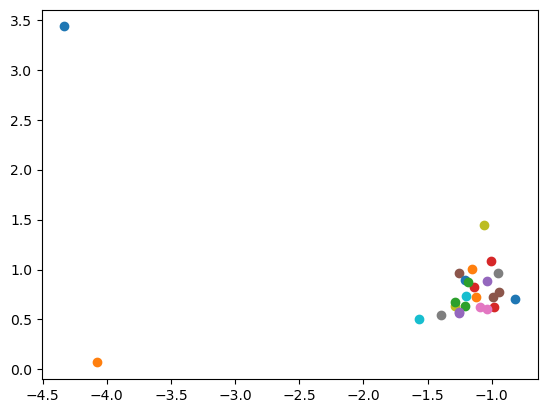

[-1.33225347  0.54605892]


In [8]:
#display for van der pol
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import gymnasium

env = gymnasium.make("VDP-v0")
observation, info = env.reset()
s=observation
#s=np.array([5.5,5.5])
x=s[0]
y=s[1]
print(s)
plt.figure(1)
plt.scatter(x,y)#,'ro')
for i in range(1000):
    a= pi(s)
    #a=np.array([0])
    obs, reward, terminated, truncated, info = env.step(a)
    s=obs
    x=s[0]
    y=s[1]
    if i % 20 ==0:  
        print(x,y,reward)
        plt.scatter(x, y)
    #print(reward)
    if (terminated or truncated):  break
env.close()
plt.show()
print(s)

In [2]:
#SAC for PDE
import gymnasium
import jax
import coax
import numpy as np
import haiku as hk
import jax.numpy as jnp
from numpy import prod
import optax
import time
import math
import random

class controller:
    def __init__(self, grid, state, num_sens):
        self.grid=grid
        self.num_sens=num_sens
        self.state=state
        self.control=[]

#need function to reduce full space to just sensors 
def sensor_meas(sensors,domain):
    #assume senors form a square grid, so take square root of number of sensors
    #assume sensors read from middle of domain
    n_sense=int(np.sqrt(sensors))
    meas=np.empty((n_sense,n_sense))
    dimx=domain.shape[0]
    dimy=domain.shape[1]
    startx=round((dimx-n_sense)/2)
    starty=round((dimy-n_sense)/2)
    for i in range(n_sense):
        for j in range(n_sense):
            meas[i,j]=float(domain[i+startx,j+starty])
    return meas.flatten()

# the name of this script
name = 'sac'

# the Pendulum MDP
env = gymnasium.make('Diffusion-v0')
obs, grid, state = env.reset(seed=random.randint(0,10000))
env = coax.wrappers.TrainMonitor(env, name=name, tensorboard_dir=f"./data/tensorboard/{name}")


def func_pi(S, is_training):
    seq = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(prod(env.action_space.shape) * 2, w_init=jnp.zeros),
        hk.Reshape((*env.action_space.shape, 2)),
    ))
    x = seq(S)
    mu, logvar = x[..., 0], x[..., 1]
    return {'mu': mu, 'logvar': logvar}


def func_q(S, A, is_training):
    seq = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(1, w_init=jnp.zeros), jnp.ravel
    ))
    X = jnp.concatenate((S, A), axis=-1)
    return seq(X)


# main function approximators
pi = coax.Policy(func_pi, env)
q1 = coax.Q(func_q, env, action_preprocessor=pi.proba_dist.preprocess_variate)
q2 = coax.Q(func_q, env, action_preprocessor=pi.proba_dist.preprocess_variate)

# target network
q1_targ = q1.copy()
q2_targ = q2.copy()

# experience tracer
tracer = coax.reward_tracing.NStep(n=5, gamma=0.9, record_extra_info=True)
buffer = coax.experience_replay.SimpleReplayBuffer(capacity=25000)
alpha = 0.2
policy_regularizer = coax.regularizers.NStepEntropyRegularizer(pi,
                                                               beta=alpha / tracer.n,
                                                               gamma=tracer.gamma,
                                                               n=[tracer.n])

# updaters (use current pi to update the q-functions and use sampled action in contrast to TD3)
qlearning1 = coax.td_learning.SoftClippedDoubleQLearning(
    q1, pi_targ_list=[pi], q_targ_list=[q1_targ, q2_targ],
    loss_function=coax.value_losses.mse, optimizer=optax.adam(1e-3),
    policy_regularizer=policy_regularizer)
qlearning2 = coax.td_learning.SoftClippedDoubleQLearning(
    q2, pi_targ_list=[pi], q_targ_list=[q1_targ, q2_targ],
    loss_function=coax.value_losses.mse, optimizer=optax.adam(1e-3),
    policy_regularizer=policy_regularizer)
soft_pg = coax.policy_objectives.SoftPG(pi, [q1_targ, q2_targ], optimizer=optax.adam(
    1e-3), regularizer=coax.regularizers.NStepEntropyRegularizer(pi,
                                                                 beta=alpha / tracer.n,
                                                                 gamma=tracer.gamma,
                                                                 n=jnp.arange(tracer.n)))

tracker=[0.,0.]

#insert controller parameters
# number of controls, control locations.  Assume control is on boundary
#here, with two control locations and 4 controls, that means that two boundaries have controls.
#In gymanisum this will be hard coded as bottom and right side, or (x,ymin) and (xmax, y)
num_sens=4*4
num_control = 4
control_size = 3 #number of grid points comprising controller
control_points = np.array([8,20]) #grid x/y locations of controllers
dx=1.
dy=1.
xmax=grid.shape[0]*dx
ymax=grid.shape[1]*dy 



#hard code control locations
control_loc=np.array([xmax, dy*control_points[0]]) #right side, 1st control point
control_loc=np.vstack([control_loc,[xmax, dy*control_points[1]]]) #right side, 2nd control point
control_loc=np.vstack([control_loc,[ymax, dx*control_points[0]]]) #top, 1st control point
control_loc=np.vstack([control_loc,[ymax, dx*control_points[1]]]) #top 2nd control point

#insert controller class initialization
actor=controller(grid,state, num_sens)

# train
while env.T < 100000:
    #modify for grid and state
    obs, grid, state = env.reset()
    actor=controller(grid, state, num_sens)
    #insert sensor measurement and conversion here
    s=sensor_meas(num_sens,state.data)
    #add x,y coordinates to make nn input vector s.  This means that must add x,y for all control points to s
    #i.e s dimension = #observation point measurements + 2*number of control points
    #x and y locations are control loc variables, so s will need to append each element of control loc into s
    for i in control_loc:
        for j in i:
            np.append(s, float(j.item()))
    
    total_reward=0
    for t in range(200):#(env.spec.max_episode_steps):
        #insert sensor measurement and conversion here
        s=sensor_meas(num_sens,state.data)
        #add x,y coordinates to make nn input vector s.  This means that must add x,y for all control points to s
        #i.e s dimension = #observation point measurements + 2*number of control points
        #x and y locations are control loc variables, so s will need to append each element of control loc into s
        for i in control_loc:
            for j in i:
                np.append(s, float(j.item()))
        a = pi(s)
        #insert boundary condition defnitiions
        left_bound=np.zeros(grid.shape[1])
        right_bound=np.zeros(grid.shape[1])
        bottom_bound=np.zeros(grid.shape[0])
        top_bound=np.zeros(grid.shape[0])
        for i in range(len(control_points)):
            start=math.floor(control_size/2)
            right_bound[control_points[i]-start:control_points[i]-start+control_size]=a[i].item()
            top_bound[control_points[i]-start:control_points[i]-start+control_size]=a[i+2].item()
        all_bound=np.vstack([left_bound, right_bound])
        all_bound=np.vstack([all_bound, bottom_bound])
        all_bound=np.vstack([all_bound, top_bound])
        #add boundary conditions to controller class instance
        actor.control=all_bound
        
        s_next, r, done, truncated, info = env.step(actor)
        implement.state.data=s_next
        # trace rewards and add transition to replay buffer
        tracer.add(s, a, r, done)
        while tracer:
            buffer.add(tracer.pop())

        # learn
        if len(buffer) >= 5000:
            transition_batch = buffer.sample(batch_size=128)

            # init metrics dict
            metrics = {}

            # flip a coin to decide which of the q-functions to update
            qlearning = qlearning1 if jax.random.bernoulli(q1.rng) else qlearning2
            metrics.update(qlearning.update(transition_batch))

            # delayed policy updates
            if env.T >= 7500 and env.T % 4 == 0:
                metrics.update(soft_pg.update(transition_batch))

            env.record_metrics(metrics)

            # sync target networks
            q1_targ.soft_update(q1, tau=0.001)
            q2_targ.soft_update(q2, tau=0.001)
        total_reward+=r
        if done or truncated:
            break

        s = s_next
    tracker.append([time.time(), total_reward])
    #generate an animated GIF to see what's going on



C:\Users\Robert\anaconda3\Lib\site-packages\gymnasium\utils\passive_env_checker.py:192: UserWarning: WARN: The result returned by `env.reset()` should be `(obs, info)` by default, , where `obs` is a observation and `info` is a dictionary containing additional information.
  logger.warn(
C:\Users\Robert\anaconda3\Lib\site-packages\coax\utils\_array.py:335: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  X = jnp.asarray(X, dtype=space.dtype)   # ensure ndarray
C:\Users\Robert\anaconda3\Lib\site-packages\coax\utils\_array.py:335: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENAB

IndexError: index 2 is out of bounds for axis 0 with size 1

In [4]:
#implement diffusion PDE with gymnasium, interior control
#review diffusion gym to make sure set up for interior control and periodic boundary
#I use the gym to define the action space, but reset and step are replaced with direct calls to pde functions

import gymnasium
import jax
import coax
import haiku as hk
import jax.numpy as jnp
from numpy import prod
import optax
import time

import random
import numpy as np
import pde
import copy
import math

import shutup;
shutup.please()

#geting warning about jax numpy converting float 62 to float 32.  The suggested fix doesn't work, so ignoring
class controller:
    def __init__(self, grid, state, num_sens):
        self.grid=grid
        self.num_sens=num_sens
        self.state=state
        self.control=[]

from pde import DiffusionPDE, ScalarField, UnitGrid

# the name of this script
name = 'sac_Diffusion'

#define number of sensors and inputs
Num_sens=3*3 #size of observation/sensor space in number of grid points
grid_dim=2 #x,y for including boundary location in alogrithim
Ns=Num_sens+grid_dim #sensors are first in s array, then x,y are last 2 elements

#to more easile use existing code for defining and using nns, use gym to define environment
#with 1 action space, and Ns dimension observation space, which will help initialize actor
env = gymnasium.make('Diffusion-v0', Ns)
observation, grid, state0 = env.reset(seed=412)

#need function to reduce full space to just sensors 
def sensor_meas(sensors,domain):
    #assume senors form a square grid, so take square root of number of sensors
    #assume sensors read from middle of domain
    n_sense=int(np.sqrt(sensors))
    meas=np.empty((n_sense,n_sense))
    dimx=domain.shape[0]
    dimy=domain.shape[1]
    startx=round((dimx-n_sense)/2)
    starty=round((dimy-n_sense)/2)
    for i in range(n_sense):
        for j in range(n_sense):
            meas[i,j]=float(domain[i+startx,j+starty])
    return meas.flatten()

def func_pi(S, is_training):
    seq = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(prod(env.action_space.shape) * 2, w_init=jnp.zeros),
        hk.Reshape((*env.action_space.shape, 2)),
    ))
    x = seq(S)
    mu, logvar = x[..., 0], x[..., 1]
    return {'mu': mu, 'logvar': logvar}


def func_q(S, A, is_training):
    seq = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(1, w_init=jnp.zeros), jnp.ravel
    ))
    X = jnp.concatenate((S, A), axis=-1)
    return seq(X)

   
# main function approximators
pi = coax.Policy(func_pi, env)
q1 = coax.Q(func_q, env, action_preprocessor=pi.proba_dist.preprocess_variate)
q2 = coax.Q(func_q, env, action_preprocessor=pi.proba_dist.preprocess_variate)

# target network
q1_targ = q1.copy()
q2_targ = q2.copy()

# experience tracer
tracer = coax.reward_tracing.NStep(n=5, gamma=0.9, record_extra_info=True)
buffer = coax.experience_replay.SimpleReplayBuffer(capacity=25000)
alpha = 0.2
policy_regularizer = coax.regularizers.NStepEntropyRegularizer(pi,
                                                               beta=alpha / tracer.n,
                                                               gamma=tracer.gamma,
                                                               n=[tracer.n])

# updaters (use current pi to update the q-functions and use sampled action in contrast to TD3)
qlearning1 = coax.td_learning.SoftClippedDoubleQLearning(
    q1, pi_targ_list=[pi], q_targ_list=[q1_targ, q2_targ],
    loss_function=coax.value_losses.mse, optimizer=optax.adam(1e-3),
    policy_regularizer=policy_regularizer)
qlearning2 = coax.td_learning.SoftClippedDoubleQLearning(
    q2, pi_targ_list=[pi], q_targ_list=[q1_targ, q2_targ],
    loss_function=coax.value_losses.mse, optimizer=optax.adam(1e-3),
    policy_regularizer=policy_regularizer)
soft_pg = coax.policy_objectives.SoftPG(pi, [q1_targ, q2_targ], optimizer=optax.adam(
    1e-3), regularizer=coax.regularizers.NStepEntropyRegularizer(pi,
                                                                 beta=alpha / tracer.n,
                                                                 gamma=tracer.gamma,
                                                                 n=jnp.arange(tracer.n)))

#Here define all boundaries to make it easier to add or change controllers
#now set up entire array for boundary coordinates.  first row is x coords, second is y coords
left_bound=np.full(len(grid.axes_coords[1]), grid.axes_bounds[0][0].item())  #
left_bound=np.vstack((left_bound, grid.axes_coords[1]))
right_bound=np.full(len(grid.axes_coords[1]), grid.axes_bounds[0][1].item())#
right_bound=np.vstack((right_bound, grid.axes_coords[1]))

bottom_bound=grid.axes_coords[0]
bottom_bound=np.vstack((bottom_bound, np.full(len(bottom_bound), grid.axes_bounds[1][0].item())))
top_bound=grid.axes_coords[0]
top_bound=np.vstack((top_bound, np.full(len(top_bound), grid.axes_bounds[1][1].item())))

#initialize arrays to hold control inputs along each boundary
left_control=np.zeros(grid.shape[1])
right_control=np.zeros(grid.shape[1])
bottom_control=np.zeros(grid.shape[0])
top_control=np.zeros(grid.shape[0])

#insert controller class initialization
actor=controller(grid,state0, Num_sens)

tracker=[0.,0.]
# train
i=0
truncated= False
while i < 100000:
    total_reward=0
    actor.state=state0
    for t in range(50):#(env.spec.max_episode_steps):
        s = sensor_meas(Num_sens, actor.state.data)
        #boundary location are input variables into the neural network
        #so, for entire control boundary cycle through and call actor network for each point
        for j in range(grid.shape[0]):
            #hard code going through x and y coor for each boundary location
            s_full=jnp.append(s,left_bound[0,j])
            s_full=jnp.append(s_full, left_bound[1,j])
            a=pi(s_full)
            if a>5:  a=np.array([5.0])
            elif a<-5:  a=-np.array([5.0])
            left_control[j]=a.item()

        actor.control=left_control
        
        s_next, r, done, truncated, info = env.step(actor)
        actor.state.data=s_next

        #if t % 10 ==0:  print(time.time()-start)
        # trace rewards and add transition to replay buffer
        tracer.add(s, a, r, done)
        while tracer:
            buffer.add(tracer.pop())

        # learn
        if len(buffer) >= 5000:
            transition_batch = buffer.sample(batch_size=128)

            # init metrics dict
            metrics = {}

            # flip a coin to decide which of the q-functions to update
            qlearning = qlearning1 if jax.random.bernoulli(q1.rng) else qlearning2
            metrics.update(qlearning.update(transition_batch))

            # delayed policy updates
            if env.T >= 7500 and env.T % 4 == 0:
                metrics.update(soft_pg.update(transition_batch))

            env.record_metrics(metrics)

            # sync target networks
            q1_targ.soft_update(q1, tau=0.001)
            q2_targ.soft_update(q2, tau=0.001)
        total_reward+=r
        if done or truncated:
            break

    tracker.append([time.time(), total_reward])

        


KeyboardInterrupt: 

In [ ]:
#implement diffusion PDE without gymnasium
#I leave in some gymanisum aspects to avoid having to modify func_pi function
#I use the gym to define the action space, but reset and step are replaced with direct calls to pde functions

import gymnasium
import jax
import coax
import haiku as hk
import jax.numpy as jnp
from numpy import prod
import optax
import time

import random
import numpy as np
import pde
import copy
import math

import shutup;
shutup.please()

#geting warning about jax numpy converting float 62 to float 32.  The suggested fix doesn't work, so ignoring


from pde import DiffusionPDE, ScalarField, UnitGrid

# the name of this script
name = 'sac_Diffusion'

#define number of sensors and inputs
Num_sens=3*3 #size of observation/sensor space in number of grid points
grid_dim=2 #x,y for including boundary location in alogrithim
Ns=Num_sens+grid_dim #sensors are first in s array, then x,y are last 2 elements

#to more easile use existing code for defining and using nns, use gym to define environment
#with 1 action space, and Ns dimension observation space, which will help initialize actor
env = gymnasium.make('Diffusion-v0', Ns)

#define grid and set environment
grid = pde.CartesianGrid([[0, 5], [0, 5]], [20, 20], periodic=[False, True]) # generate grid

def reward_calc(Num_sens, result):
    #reward_calac determines reward from pass sensor measurements based on target
    #hard-coded in reward_calc function
    target=np.array([[1.,2.,1.],[2.,3.,2.],[1.,2.,1.]])#,[0.5,0.5,0.5]])
    #use eucliead norm over n gird points
    #first reduce state to sensor points
    n_sense=int(np.sqrt(Num_sens))
    meas=np.empty((n_sense,n_sense))
    dimx=result.data.shape[0]
    dimy=result.data.shape[1]
    startx=round((dimx-n_sense)/2)
    starty=round((dimy-n_sense)/2)
    for i in range(n_sense):
        for j in range(n_sense):
            meas[i,j]=float(result.data[i+startx,j+starty])
    reward=(meas-target)**2
    reward=1*math.sqrt(np.sum(np.sum(reward)))
    return reward

#need function to reduce full space to just sensors 
def sensor_meas(sensors,domain):
    #assume senors form a square grid, so take square root of number of sensors
    #assume sensors read from middle of domain
    n_sense=int(np.sqrt(sensors))
    meas=np.empty((n_sense,n_sense))
    dimx=domain.shape[0]
    dimy=domain.shape[1]
    startx=round((dimx-n_sense)/2)
    starty=round((dimy-n_sense)/2)
    for i in range(n_sense):
        for j in range(n_sense):
            meas[i,j]=float(domain[i+startx,j+starty])
    return meas.flatten()

def func_pi(S, is_training):
    seq = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(prod(env.action_space.shape) * 2, w_init=jnp.zeros),
        hk.Reshape((*env.action_space.shape, 2)),
    ))
    x = seq(S)
    mu, logvar = x[..., 0], x[..., 1]
    return {'mu': mu, 'logvar': logvar}


def func_q(S, A, is_training):
    seq = hk.Sequential((
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(8), jax.nn.relu,
        hk.Linear(1, w_init=jnp.zeros), jnp.ravel
    ))
    X = jnp.concatenate((S, A), axis=-1)
    return seq(X)

   
# main function approximators
pi = coax.Policy(func_pi, env)
q1 = coax.Q(func_q, env, action_preprocessor=pi.proba_dist.preprocess_variate)
q2 = coax.Q(func_q, env, action_preprocessor=pi.proba_dist.preprocess_variate)

# target network
q1_targ = q1.copy()
q2_targ = q2.copy()

# experience tracer
tracer = coax.reward_tracing.NStep(n=5, gamma=0.9, record_extra_info=True)
buffer = coax.experience_replay.SimpleReplayBuffer(capacity=25000)
alpha = 0.2
policy_regularizer = coax.regularizers.NStepEntropyRegularizer(pi,
                                                               beta=alpha / tracer.n,
                                                               gamma=tracer.gamma,
                                                               n=[tracer.n])

# updaters (use current pi to update the q-functions and use sampled action in contrast to TD3)
qlearning1 = coax.td_learning.SoftClippedDoubleQLearning(
    q1, pi_targ_list=[pi], q_targ_list=[q1_targ, q2_targ],
    loss_function=coax.value_losses.mse, optimizer=optax.adam(1e-3),
    policy_regularizer=policy_regularizer)
qlearning2 = coax.td_learning.SoftClippedDoubleQLearning(
    q2, pi_targ_list=[pi], q_targ_list=[q1_targ, q2_targ],
    loss_function=coax.value_losses.mse, optimizer=optax.adam(1e-3),
    policy_regularizer=policy_regularizer)
soft_pg = coax.policy_objectives.SoftPG(pi, [q1_targ, q2_targ], optimizer=optax.adam(
    1e-3), regularizer=coax.regularizers.NStepEntropyRegularizer(pi,
                                                                 beta=alpha / tracer.n,
                                                                 gamma=tracer.gamma,
                                                                 n=jnp.arange(tracer.n)))

#Here define all boundaries to make it easier to add or change controllers
#now set up entire array for boundary coordinates.  first row is x coords, second is y coords
left_bound=grid.axes_coords[1]
left_bound=np.vstack((left_bound, np.full(len(left_bound), grid.axes_bounds[0][0].item())))
right_bound=grid.axes_coords[1]
right_bound=np.vstack((right_bound, np.full(len(right_bound), grid.axes_bounds[0][1].item())))
bottom_bound=grid.axes_coords[0]
bottom_bound=np.vstack((bottom_bound, np.full(len(bottom_bound), grid.axes_bounds[1][0].item())))
top_bound=grid.axes_coords[0]
top_bound=np.vstack((top_bound, np.full(len(top_bound), grid.axes_bounds[1][1].item())))

#initialize arrays to hold control inputs along each boundary
left_control=np.zeros(grid.shape[1])
right_control=np.zeros(grid.shape[1])
bottom_control=np.zeros(grid.shape[0])
top_control=np.zeros(grid.shape[0])

tracker=[0.,0.]
# train
i=0
truncated= False
while i < 100000:
    total_reward=0
    state = ScalarField.random_uniform(grid, 0.0, 0.2)
    s = sensor_meas(Num_sens, state.data)
    for t in range(50):#(env.spec.max_episode_steps):
        #boundary location are input variables into the neural network
        #so, for entire control boundary cycle through and call actor network for each point
        for j in range(grid.shape[0]):
            #hard code going through x and y coor for each boundary location
            s_full=jnp.append(s,left_bound[0,j])
            s_full=jnp.append(s_full, left_bound[1,j])
            a=pi(s_full)
            if a>5:  a=np.array([5.0])
            elif a<-5:  a=-np.array([5.0])
            left_control[j]=a.item()
        bc_x_right={"value": 0}
        bc_x_left={"value": left_control}
        bc_x=[bc_x_left, bc_x_right]
        bc_y="periodic"
        #s_next, r, done, truncated, info = env.step(a)
        start=time.time()
        eq = DiffusionPDE(diffusivity=0.5, bc=[bc_x, bc_y])
        result = eq.solve(state, t_range=0.2, adaptive=True, tracker=None)
        s_next=result.data
        
        r=reward_calc(Num_sens, result)
        if t<50:  done=False
        if t % 10 ==0:  print(time.time()-start)
        # trace rewards and add transition to replay buffer
        tracer.add(s, a, r, done)
        while tracer:
            buffer.add(tracer.pop())

        # learn
        if len(buffer) >= 5000:
            transition_batch = buffer.sample(batch_size=128)

            # init metrics dict
            metrics = {}

            # flip a coin to decide which of the q-functions to update
            qlearning = qlearning1 if jax.random.bernoulli(q1.rng) else qlearning2
            metrics.update(qlearning.update(transition_batch))

            # delayed policy updates
            if env.T >= 10 and env.T % 4 == 0:
                metrics.update(soft_pg.update(transition_batch))
                print(r, i)

            env.record_metrics(metrics)

            # sync target networks
            q1_targ.soft_update(q1, tau=0.001)
            q2_targ.soft_update(q2, tau=0.001)
        total_reward+=r
        if done or truncated:
            break
        state=result
        s = sensor_meas(Num_sens,s_next)
    tracker.append([time.time(), total_reward])

        
